In [ ]:
import pandas as pd
import dash
from dash import html
from dash import dcc
from dash.dependencies import Input, Output
import plotly.express as px

# Reading the airline data into pandas dataframe
spacex_df = pd.read_csv("spacex_launch_dash.csv")
max_payload = spacex_df['Payload Mass (kg)'].max()
min_payload = spacex_df['Payload Mass (kg)'].min()

#print(spacex_df['Launch Site'].unique())

# Creating a dash application
app = dash.Dash(__name__)

# Creating an app layout
app.layout = html.Div(children=[html.H1('SpaceX Launch Records Dashboard',
                                        style={'textAlign': 'center', 'color': '#503D36',
                                               'font-size': 40}),
                                # Adding a dropdown list to enable Launch Site selection
                                # The default select value is for ALL sites
                                dcc.Dropdown(id='site-dropdown',
                                             options=[
                                                    {'label': 'All Sites', 'value': 'ALL'},
                                                    {'label': 'CCAFS LC-40', 'value': 'CCAFS LC-40'},
                                                    {'label': 'VAFB SLC-4E', 'value': 'VAFB SLC-4E'},
                                                    {'label': 'KSC LC-39A', 'value': 'KSC LC-39A'},
                                                    {'label': 'CCAFS SLC-40', 'value': 'CCAFS SLC-40'}],
                                             value='ALL',
                                             placeholder="State",
                                             searchable=True
                                            ),
                                html.Br(),

                                # Adding a pie chart to show the total successful launches count for all sites
                                # If a specific launch site was selected, show the Success vs. Failed counts for the site
                                html.Div(dcc.Graph(id='success-pie-chart')),
                                html.Br(),

                                html.P("Payload range (Kg):"),
                                # Adding a slider to select payload range
                                dcc.RangeSlider(id='payload-slider',
                                                min=0, max=10000, step=1000,
                                                marks={0: '0', 100: '100'},
                                                value=[min_payload, max_payload]),

                                # Adding a scatter chart to show the correlation between payload and launch success
                                html.Div(dcc.Graph(id='success-payload-scatter-chart')),
                                ])


# Adding a callback function for `site-dropdown` as input, `success-pie-chart` as output
# Function decorator to specify function input and output
@app.callback(Output(component_id='success-pie-chart', component_property='figure'),
              Input(component_id='site-dropdown', component_property='value'))
def get_pie_chart(entered_site):    
    if entered_site == 'ALL':
        fig = px.pie(spacex_df, 
                     values='class', 
                     names='Launch Site', 
                     title='Total Success Launches By Site')        
    else:
        filtered_df = spacex_df[spacex_df['Launch Site'] == entered_site]
        filtered_df = filtered_df.groupby('class').count().reset_index()        
        fig = px.pie(filtered_df, 
                     values='Unnamed: 0', 
                     names='class', 
                     title='Total Launches for site {}'.format(entered_site))        
        # return the outcomes piechart for a selected site
    return fig


# Adding a callback function for `site-dropdown` and `payload-slider` as inputs, `success-payload-scatter-chart` as output
@app.callback(Output(component_id='success-payload-scatter-chart', component_property='figure'),
              Input(component_id='site-dropdown', component_property='value'), 
              Input(component_id="payload-slider", component_property="value"))
def get_scatter_chart(entered_site, payload_range):
    print('Params: {} {}'.format(entered_site, payload_range))
    if entered_site == 'ALL':
        filtered_df = spacex_df[(spacex_df['Payload Mass (kg)'] >= int(payload_range[0])) &
                                (spacex_df['Payload Mass (kg)'] <= int(payload_range[1]))
                               ]
        fig = px.scatter(filtered_df, x='Payload Mass (kg)', y='class', color='Booster Version Category', title='All sites - payload mass between {:8,d}kg and {:8,d}kg'.format(int(payload_range[0]),int(payload_range[1])))
    else:
        filtered_df = spacex_df[(spacex_df['Launch Site'] == entered_site) & 
                                (spacex_df['Payload Mass (kg)'] >= int(payload_range[0])) &
                                (spacex_df['Payload Mass (kg)'] <= int(payload_range[1]))
                               ]
        fig = px.scatter(filtered_df, x='Payload Mass (kg)', y='class', color='Booster Version Category', title='Site {} - payload mass between {:8,d}kg and {:8,d}kg'.format(entered_site,int(payload_range[0]),int(payload_range[1])))
    
    return fig


# Runing the app
if __name__ == '__main__':
    app.run_server(debug=True)

# Since GitHub cannot show the Dash App, so attaching the following image here:

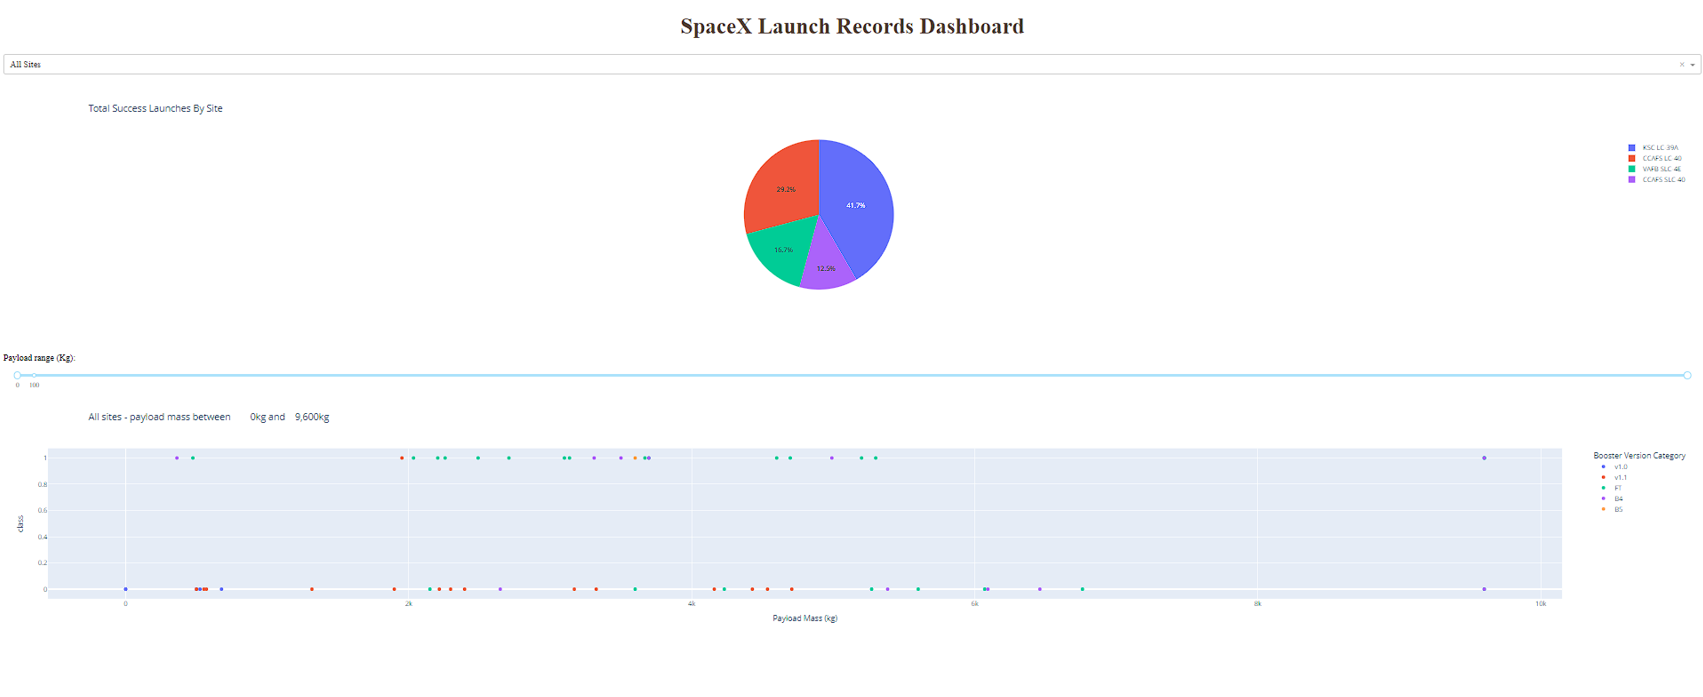

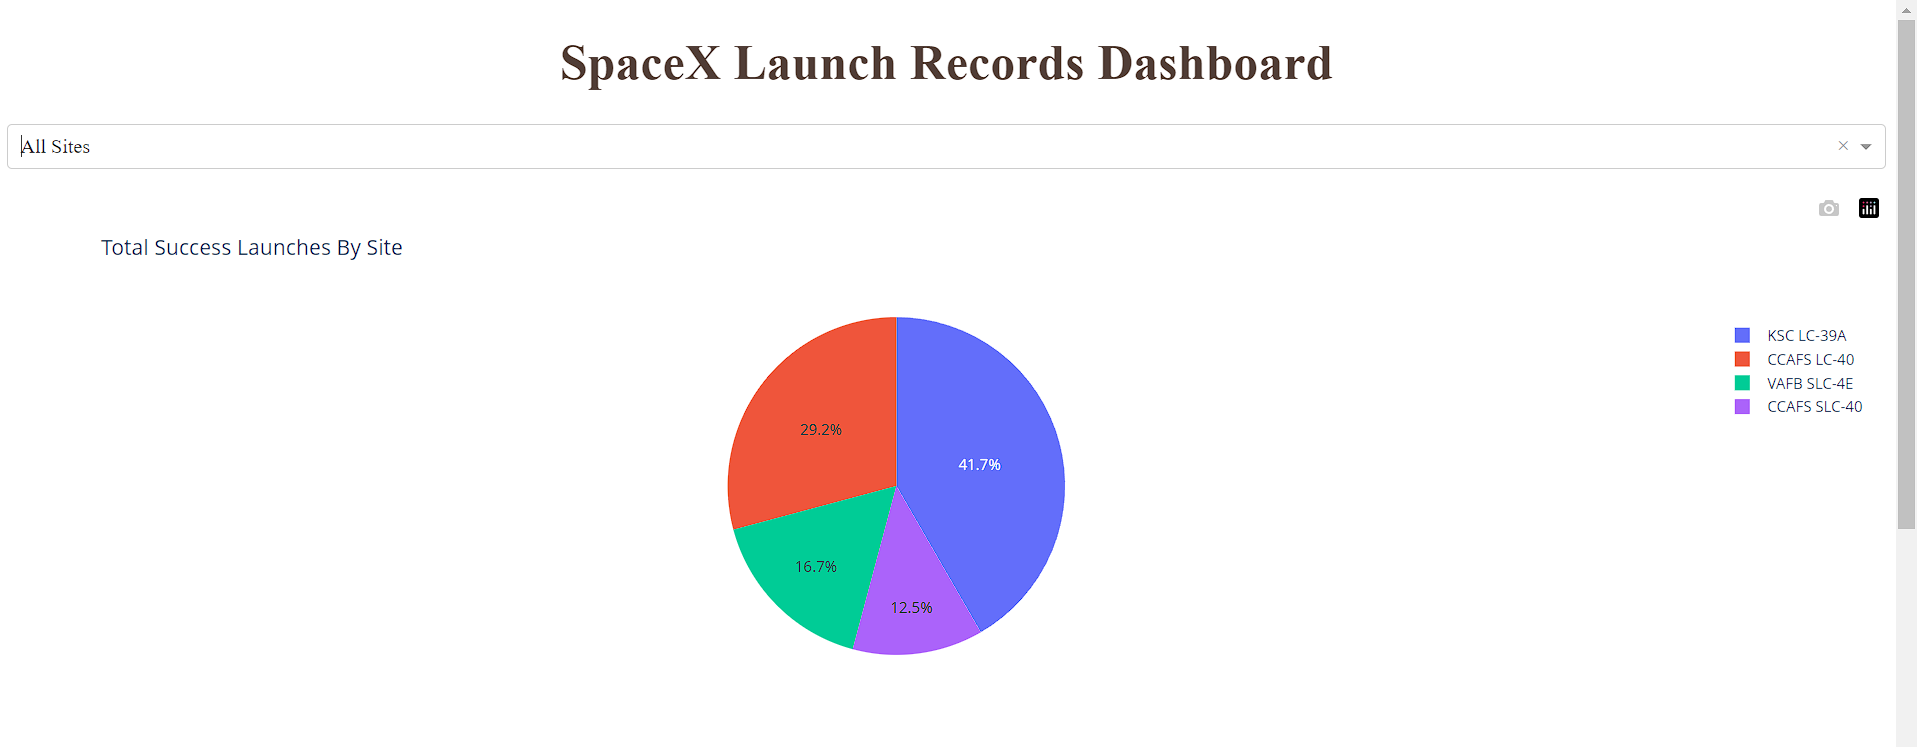

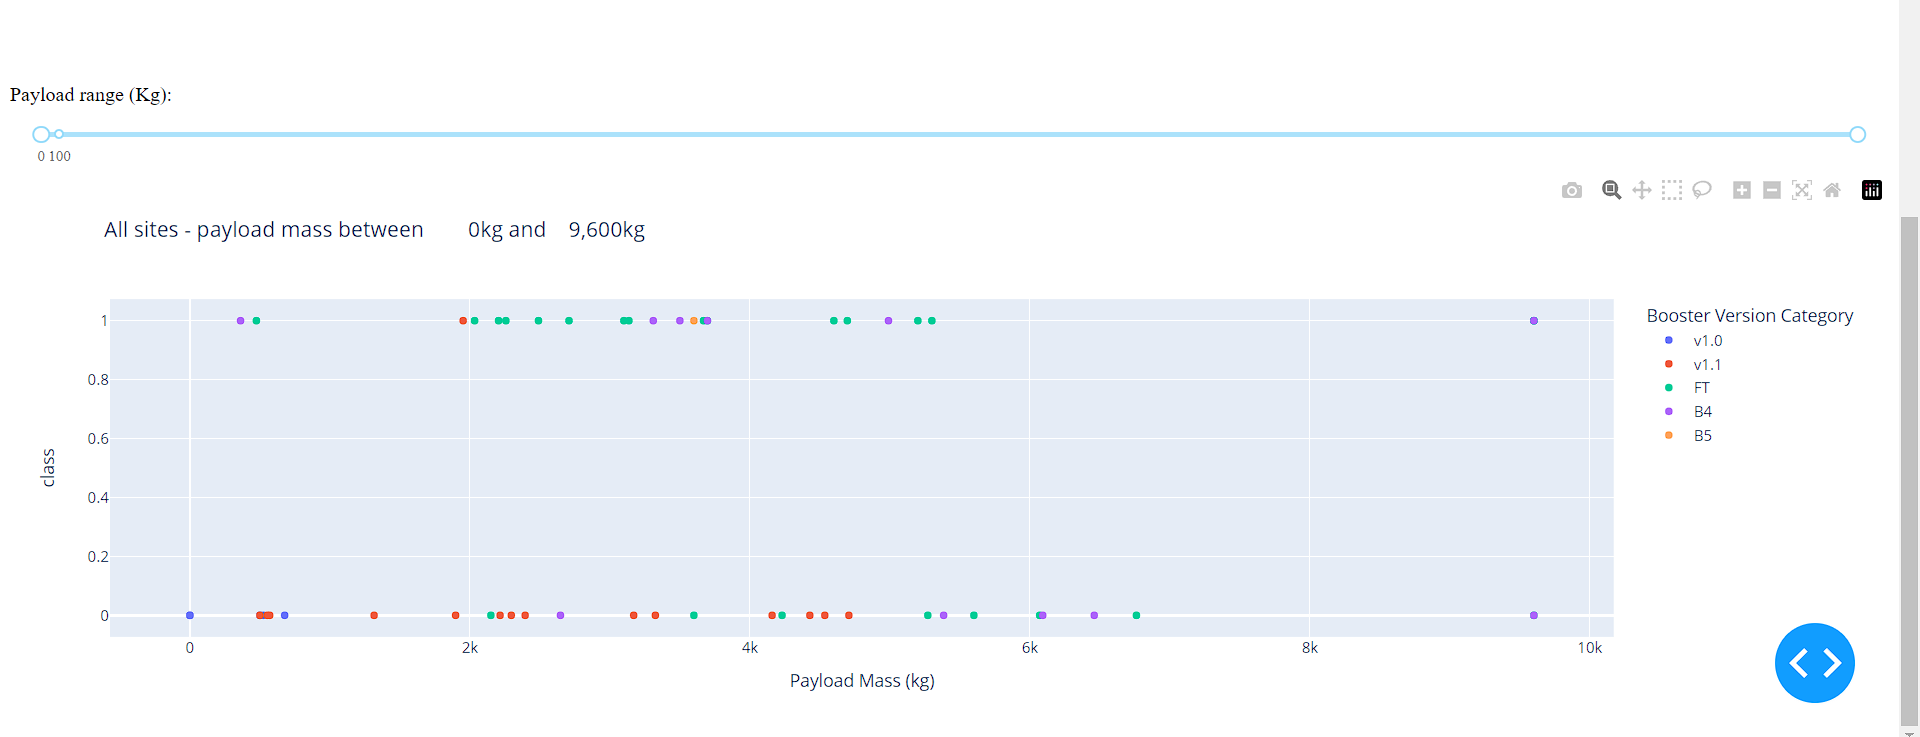

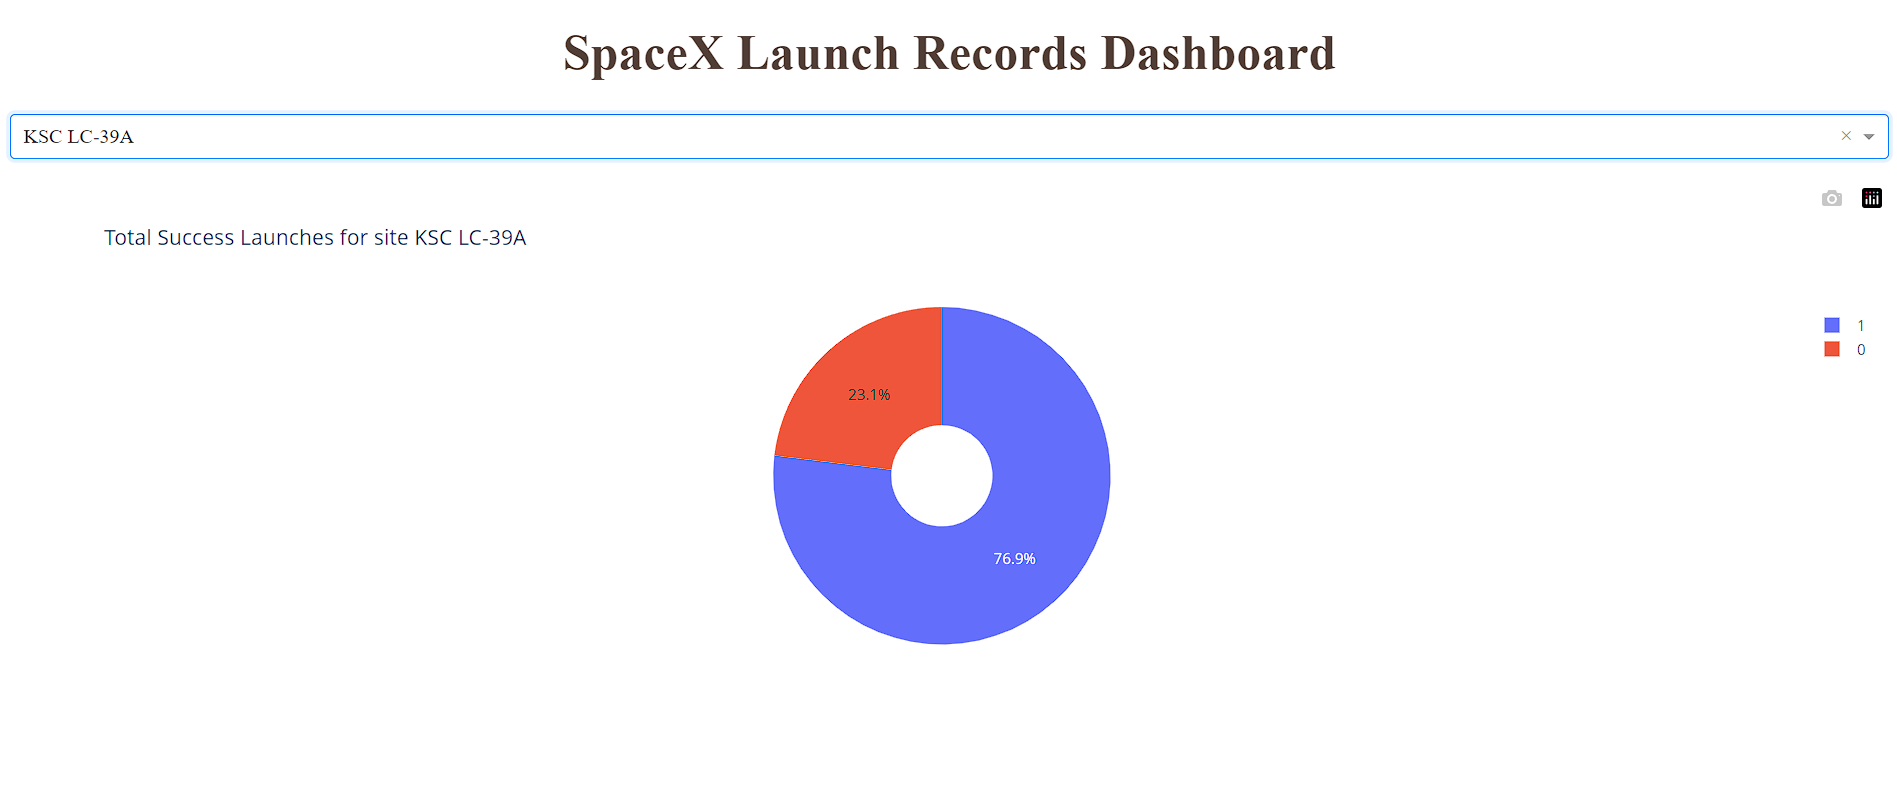